Generates data for tests in `test_dist_enum`.

In [1]:
%load_ext autoreload
%autoreload 2

The test that compares two different ways of enumerating products in `tests/test_dist_enum.py`.

In [2]:
from pathlib import Path

import asf_search as asf
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from pandas.testing import assert_frame_equal
from rasterio.crs import CRS
from shapely.geometry import Point
from tqdm import tqdm

from dist_s1_enumerator.mgrs_burst_data import (
    get_burst_ids_in_mgrs_tiles,
    get_burst_table,
    get_burst_table_from_mgrs_tiles,
    get_mgrs_table,
    get_mgrs_tile_table_by_ids,
    get_mgrs_tiles_overlapping_geometry,
)

/Users/cmarshak/miniforge3/envs/dist-s1-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
LOOKBACK_STRATEGY = 'multi_window'

SITE = "los_angeles"  # 'los_angeles', 'greenland', 'wax_lake'

CONFIG = {
    "wax_lake": {
        "geo": Point(-91.45, 29.5),
        "mgrs_tile_ids": ["15RXN"],
        "track_numbers": [63],
    },
    "los_angeles": {
        "geo": Point(-118, 34).buffer(0.25),
        "mgrs_tile_ids": ["11SLT", "11SLU", "11SMT"],
        "track_numbers": None,
    },
    "greenland": {
        "geo": Point(-46, 71),
        "mgrs_tile_ids": ["22WFD"],
        "track_numbers": None,
    },
    "aleuatian_antimeridian": {
        "geo": Point(179.87, 51.86),
        "mgrs_tile_ids": ["01UBT"],
        "track_numbers": None,
    },
    # NO data available...
    # "ilha_mexiana": {
    #     "geo": Point(-49.75, 0).buffer(0.2),
    #     "mgrs_tile_ids": ["22NFF"],
    #     "track_numbers": [148],
    # },
}

DATA = CONFIG[SITE]
DATA

{'geo': <POINT (-91.45 29.5)>,
 'mgrs_tile_ids': ['15RXN'],
 'track_numbers': [63]}

In [4]:
geo = DATA["geo"]
df_aoi = gpd.GeoDataFrame(geometry=[geo], crs=CRS.from_epsg(4326))
df_mgrs_tiles = get_mgrs_tiles_overlapping_geometry(geo)
df_mgrs_tiles.head()

,mgrs_tile_id,utm_epsg,utm_wkt,geometry
0,15RXN,32615,"MULTIPOLYGON(((600000 3300000,600000 3190200,7...","POLYGON ((-91.96499 29.82641, -91.97495 28.835..."


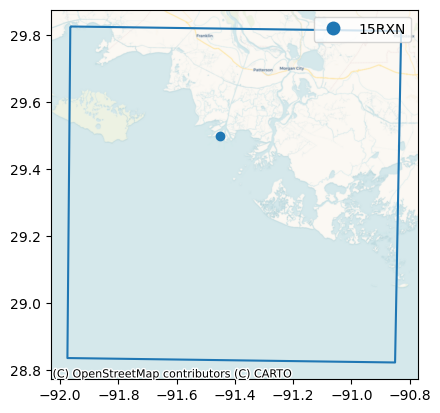

In [5]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.geometry = df_mgrs_tiles_plot.geometry.boundary
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, legend=True, ax=ax
)
df_aoi.plot(ax=ax)
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)
if SITE == "aleuatian_antimeridian":
    ax.set_xlim(178, 180)

In [6]:
mgrs_tile_ids = DATA["mgrs_tile_ids"]
mgrs_tile_ids

['15RXN']

In [7]:
df_bursts = get_burst_table_from_mgrs_tiles(mgrs_tile_ids)
df_bursts.head()

,jpl_burst_id,track_number,acq_group_id_within_mgrs_tile,mgrs_tile_id,geometry
0,T063-133337-IW3,63,0,15RXN,"POLYGON ((-91.1627 28.57844, -90.35433 28.6981..."
1,T063-133338-IW2,63,0,15RXN,"POLYGON ((-92.07298 28.55011, -91.15958 28.692..."
2,T063-133338-IW3,63,0,15RXN,"POLYGON ((-91.19651 28.74463, -90.38697 28.864..."
3,T063-133339-IW2,63,0,15RXN,"POLYGON ((-92.10828 28.71639, -91.19336 28.858..."
4,T063-133339-IW3,63,0,15RXN,"POLYGON ((-91.23035 28.91082, -90.41946 29.030..."


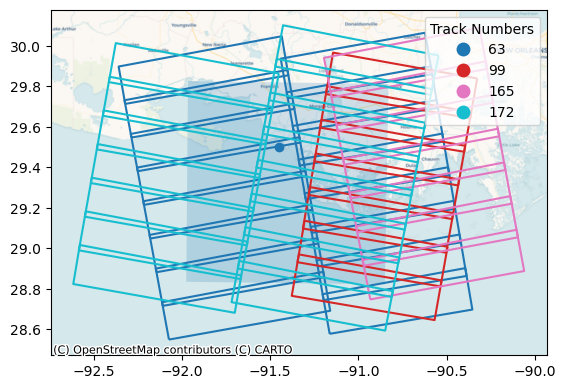

In [8]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, ax=ax, alpha=0.2
)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot.plot(column="track_number", categorical=True, ax=ax, legend=True)
leg = ax.get_legend()
leg.set_title("Track Numbers")
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)
if SITE == "aleuatian_antimeridian":
    ax.set_xlim(178, 180)

In [9]:
delta_window_days = 365
if LOOKBACK_STRATEGY == 'immediate_lookback': 
    delta_lookback_days = 0
    max_pre_imgs_per_burst = 10
elif LOOKBACK_STRATEGY == 'multi_window':
    delta_lookback_days = 365
    max_pre_imgs_per_burst = (5, 5, 5)

# Example test

In [10]:
from dist_s1_enumerator.asf import get_rtc_s1_ts_metadata_from_mgrs_tiles
from dist_s1_enumerator.dist_enum import (
    enumerate_dist_s1_products,
    enumerate_one_dist_s1_product,
)

In [11]:
track_numbers = DATA["track_numbers"]
track_numbers

[63]

In [16]:
asf.constants.INTERNAL.CMR_TIMEOUT = 300

In [17]:
df_ts = get_rtc_s1_ts_metadata_from_mgrs_tiles(
    mgrs_tile_ids, track_numbers=track_numbers
)
df_ts.head()

,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token
0,OPERA_L2_RTC-S1_T063-133337-IW3_20220101T00102...,T063-133337-IW3,2022-01-01 00:10:21+00:00,2022-01-01,VV+VH,63,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.16935 28.57693, -90.33732 28.705...",15RXN,0,63
1,OPERA_L2_RTC-S1_T063-133337-IW3_20220113T00102...,T063-133337-IW3,2022-01-13 00:10:20+00:00,2022-01-13,VV+VH,63,489,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17054 28.57716, -90.33852 28.705...",15RXN,0,63
2,OPERA_L2_RTC-S1_T063-133337-IW3_20220125T00102...,T063-133337-IW3,2022-01-25 00:10:20+00:00,2022-01-25,VV+VH,63,491,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17052 28.57731, -90.3385 28.7054...",15RXN,0,63
3,OPERA_L2_RTC-S1_T063-133337-IW3_20220206T00101...,T063-133337-IW3,2022-02-06 00:10:19+00:00,2022-02-06,VV+VH,63,493,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17071 28.57759, -90.33869 28.705...",15RXN,0,63
4,OPERA_L2_RTC-S1_T063-133337-IW3_20220218T00101...,T063-133337-IW3,2022-02-18 00:10:19+00:00,2022-02-18,VV+VH,63,495,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17005 28.57644, -90.32587 28.706...",15RXN,0,63


In [18]:
df_ts.track_number.unique()

array([63])

In [36]:
data_dir = Path("rtc_s1_ts_metadata")
data_dir.mkdir(exist_ok=True, parents=True)

mgrs_tile_token = "_".join(mgrs_tile_ids)
file_name = f"mgrs{mgrs_tile_token}.parquet"

# Time series doesn't care about strategy!
# if LOOKBACK_STRATEGY == 'multi_window':
#     file_name.replace(".parquet", f"__{LOOKBACK_STRATEGY}.parquet")

if track_numbers is not None:
    track_token = "_".join(list(map(str, track_numbers)))
    file_name = file_name.replace(".parquet", f"__track{track_token}.parquet")
df_ts.to_parquet(data_dir / file_name)

In [37]:
df_products = enumerate_dist_s1_products(df_ts, mgrs_tile_ids, lookback_strategy=LOOKBACK_STRATEGY, delta_lookback_days=delta_lookback_days, delta_window_days=delta_window_days)
df_products.head()

Enumerate by MGRS tiles: 100%|█| 1/1 [00:00<0


,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token,input_category,product_id
0,OPERA_L2_RTC-S1_T063-133337-IW3_20240408T00103...,T063-133337-IW3,2024-04-08 00:10:31+00:00,2024-04-08,VV+VH,63,625,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17014 28.5777, -90.32602 28.7076...",15RXN,0,63,pre,0
1,OPERA_L2_RTC-S1_T063-133337-IW3_20240408T00103...,T063-133337-IW3,2024-04-08 00:10:31+00:00,2024-04-08,VV+VH,63,625,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17014 28.5777, -90.32602 28.7076...",15RXN,0,63,pre,0
2,OPERA_L2_RTC-S1_T063-133337-IW3_20240408T00103...,T063-133337-IW3,2024-04-08 00:10:31+00:00,2024-04-08,VV+VH,63,625,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17014 28.5777, -90.32602 28.7076...",15RXN,0,63,pre,0
3,OPERA_L2_RTC-S1_T063-133338-IW2_20240408T00103...,T063-133338-IW2,2024-04-08 00:10:33+00:00,2024-04-08,VV+VH,63,625,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.08083 28.5436, -91.12317 28.6970...",15RXN,0,63,pre,0
4,OPERA_L2_RTC-S1_T063-133338-IW2_20240408T00103...,T063-133338-IW2,2024-04-08 00:10:33+00:00,2024-04-08,VV+VH,63,625,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.08083 28.5436, -91.12317 28.6970...",15RXN,0,63,pre,0


In [25]:
df_post = df_products[df_products.input_category == "post"].reset_index(
    drop=True
)
df_tmp = (
    df_post[
        [
            "product_id",
            "acq_date_for_mgrs_pass",
            "track_number",
            "mgrs_tile_id",
            "track_token",
        ]
    ]
    .drop_duplicates(subset="product_id")
    .sort_values(by="acq_date_for_mgrs_pass")
)
mgrs_tile_ids_post = df_tmp["mgrs_tile_id"].tolist()
product_ids = df_tmp["product_id"].tolist()
post_dates = df_tmp["acq_date_for_mgrs_pass"].tolist()
track_tokens_post = df_tmp["track_token"].tolist()
track_numbers_post_lst = [
    [int(track) for track in token.split("_")] for token in track_tokens_post
]

In [28]:
for mgrs_tile_id_post, product_id, track_numbers_post, post_date in tqdm(
    zip(mgrs_tile_ids_post, product_ids, track_numbers_post_lst, post_dates),
    total=len(post_dates),
):
    df_one_product = enumerate_one_dist_s1_product(
        mgrs_tile_id_post,
        track_number=track_numbers_post,
        post_date=pd.Timestamp(post_date),
        lookback_strategy=LOOKBACK_STRATEGY,
        delta_lookback_days=delta_lookback_days,
        delta_window_days=delta_window_days,
        max_pre_imgs_per_burst=max_pre_imgs_per_burst
    )
    df_one_product_alt = (
        df_products[df_products.product_id == product_id]
        .reset_index(drop=True)
        .drop(columns="product_id")
    )
    df_pre_alt = df_one_product_alt[
        df_one_product_alt.input_category == "pre"
    ].sort_values(by=['opera_id']).reset_index(drop=True)
    df_post_alt = df_one_product_alt[
        df_one_product_alt.input_category == "post"
    ].sort_values(by=['opera_id']).reset_index(drop=True)

    df_pre = df_one_product[df_one_product.input_category == "pre"].sort_values(by=['opera_id']).reset_index(
        drop=True
    )
    df_post = df_one_product[
        df_one_product.input_category == "post"
    ].sort_values(by=['opera_id']).reset_index(drop=True)

    assert_frame_equal(df_pre, df_pre_alt, atol=1e-7)
    assert_frame_equal(df_post, df_post, atol=1e-7)

  5%|▎      | 4/77 [06:35<2:00:14, 98.83s/it]


KeyboardInterrupt: 